<a href="https://colab.research.google.com/github/karencfisher/ufosightings/blob/master/NUFORC_ufo_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Close Encounters of the Data Kind: Exploring The NUFORC UFO Sightings Data

The dataset being explored here is from https://www.kaggle.com/NUFORC/ufo-sightings. It is a dataset of UFO sightings compiled from reports of the National UFO Reporting Center. I have used the 'scrubbed' version, though it still has plenty of issues. And this seems just a beginning of investigation into the subject.

**About the data source**

The data herein is compiled from NUFORC, which says "the Center's primary function over the past two decades has been to receive, record, and to the greatest degree possible, corroborate and document reports from individuals who have been witness to unusual, possibly UFO-related events." (http://www.nuforc.org/General.html). The principle means for data collection is via a 24 hour hotline which anyone can contact to report sightings. They also state that "the hotline is well known by law enforcement agencies, FAA ARTCC's and flight service stations, National Weather Services offices, military facilities, NASA, and many 911 emergency dispatch centers all across the United States and in many parts of Canada."

The specific dataset herein explored was scraped, geolocated, and time standardized from NUFORC data by Sigmond Axel, https://github.com/planetsig/ufo-reports.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [0]:
ufo1_url ='https://raw.githubusercontent.com/karencfisher/ufosightings/master/scrubbed.csv'

##Data Cleaning
While at first glance the dataset did not look too bad, it had a number of inconsitencies. While longtiudes were in floating point format, for example, latitudes were expressed as strings. Durations in seconds were strings, with some extraneous characters that had to be removed before converting them to floating point (as some were decimals). There were a fair number of missing values: changed durations to the median values, string values of shape and comments to 'unknown.' There even some times of 24:00 rather than 00:00, I would assume denoting midnight.

And at what was to be the 'finale,' as it were plotting sightings on part of the U.S. map, I also discovered the Longitude column heading had a trailing space. Guess that's why a big part of data science is cleaning data?

But finally it was in usable form

In [3]:
# load and clean first ufo dataset
ufo1_df = pd.read_csv(ufo1_url)

# filter for just US cases
ufo1_df = ufo1_df[ufo1_df['country']== 'us']

# turned out to have some invalid values ('24:00') converted those to '00:00' (properly midnight)
ufo1_df['datetime'] = ufo1_df['datetime'].str.replace('24:00', '00:00')
# convert datetime column from string to datetime
ufo1_df['datetime'] = pd.to_datetime(ufo1_df['datetime'], infer_datetime_format=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
# had longitudes as float, but latitudes as strings. So fix that.
ufo1_df['latitude'] = ufo1_df['latitude'].apply(lambda x: float(x))

# and change 'duration (seconds)' to float, after cleaning up some non-numeric characters
ufo1_df['duration (seconds)'] = ufo1_df['duration (seconds)'].str.extract('(\d+)', expand=False)
ufo1_df['duration (seconds)'] = ufo1_df['duration (seconds)'].apply(lambda x: float(x))

#change column to just 'duration' and drop unneeded columns (duration in hours/min and date posted)
ufo1_df.rename(columns={'duration (seconds)': 'duration'}, inplace=True)
ufo1_df.drop(['duration (hours/min)', 'date posted'], axis=1, inplace=True)

# standardize capitalizations of city names, states and country
ufo1_df['city'] = ufo1_df['city'].str.title()
ufo1_df['state'] = ufo1_df['state'].str.upper()
ufo1_df['country'] = ufo1_df['country'].str.upper()

# cleanup NaNs: durations with median value, shape and comments with 'Unknown'
ufo1_df.fillna(value={'duration': ufo1_df['duration'].median(), 
                       'shape': 'unknown',
                       'comments': 'unknown'}, inplace=True)

# And some one put a space after 'longitude '. Sheesh.
ufo1_df.rename(columns={'longitude ': 'longitude'}, inplace=True)

ufo1_df.sample(10)

,datetime,city,state,country,shape,duration,comments,latitude,longitude
11486,2014-01-01 23:00:00,North Myrtle Beach,SC,US,fireball,3600.0,Chinese lanterns with orange glow very popular...,33.815833,-78.680278
20291,2011-12-24 06:50:00,Phoenix,AZ,US,unknown,900.0,Bright Blue &amp; Red Object in North Valley,33.448333,-112.073333
72629,2004-08-09 21:55:00,Spanish Fork,UT,US,triangle,180.0,unnatral high flying craft flys faster than an...,40.115000,-111.654167
31481,1979-03-15 19:00:00,Woodinville (N.E. 189Th Street),WA,US,light,60.0,In 1979&#44 a large circular light was seen ov...,47.754444,-122.162222
79454,2013-09-05 07:16:00,Hunt Valley,MD,US,sphere,180.0,Shiny sphere seen over 83 south at Hunt Valley...,39.499722,-76.641389
62112,2010-07-04 21:15:00,Derby,KS,US,other,10800.0,Formations of glowing and non-glowing spheres ...,37.545556,-97.268611
68448,2011-08-21 13:30:00,San Clemente,CA,US,teardrop,180.0,1 craft hovering over shore. Clear day 1/2 mi...,33.426944,-117.611111
32589,2011-03-20 22:00:00,Sylvania,OH,US,light,10.0,NW Ohio 3 low flying white lights moving toget...,41.718889,-83.713056
78273,2011-09-28 20:55:00,Vancouver,WA,US,sphere,180.0,Slow moving flaming fireball moving east to we...,45.638889,-122.660278
63696,1981-07-08 20:00:00,Christiansburg,VA,US,light,600.0,Observed light only&#44 first slowly moving&#4...,37.129722,-80.409167


##Time Span

The data covered a period from 1910 to 2014. However, there were fairly few sightings included in the first half of the 20th century (there being only a total of14 cases from 1910 - 1940). What is there also seems incomplete, which is not surprising as there probably were yet no serious tracking of sightings (NUFORC itself was founded in 1974). Since that, and given that the modern/popular interest in UFOs began with 1947 with Kenneth Arnold's 'flying saucer' sighting and the Roswell incident, I have limited the data to look at here from 1940-2014 (with some reasonable skeptical about completeness of data preceding 1974).

This data also seems to fall short in the sightings recorded for 2014, the latest date recorded sighting being May 8 -- less than half way into that year. Comparison with a plot from https://www.statista.com/chart/8452/ufo-sightings-are-at-record-heights/, which shows a peak of 8,696 sightings culled also from NUFORC's databases.

I then divided the years into periods of decades, and plotted number of sightings in each. Since the available data is limited even in 2014, it is hard to discern if the trend from 2000 - 2010 rose or fell in 2010 - 2020. The increase in the first decade of the 21st century is significant however, possibly reflecting popular concerns about the millenium. 

The Statista article, by comparison, shows an increase through 2014, followed by a significant decline thereafter. It shows the same data for 2012 and 2013 (a slight dip after perhaps the intense interest in 2012 with popular belief that the aliens would be arriving at that time).

In [5]:
ufo1_df[ufo1_df['datetime'].dt.year < 1940]['datetime'].describe()

count                      14
unique                     14
top       1939-06-30 20:00:00
freq                        1
first     1910-01-01 00:00:00
last      1939-07-07 02:00:00
Name: datetime, dtype: object

In [6]:
cond = ufo1_df['datetime'].dt.year >= 1940
ufo1_df = ufo1_df[cond]
ufo1_df['datetime'].describe()

count                   65100
unique                  56966
top       2010-07-04 22:00:00
freq                       31
first     1941-06-01 13:00:00
last      2014-05-08 00:00:00
Name: datetime, dtype: object

In [7]:
ufo1_df['year'] = ufo1_df['datetime'].dt.year
decade_bins = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2014]
decade_labels = ['1940-50','1950-60', '1960-70', '1970-80', '1980-90', '1990-2000', '2000-10', '2010-14']
ufo1_df['decade'] = pd.cut(ufo1_df['datetime'].dt.year, bins=decade_bins, labels=decade_labels)
ufo1_df[['datetime', 'year','decade']].sample(10)

,datetime,year,decade
78865,2001-09-03 21:25:00,2001,2000-10
16298,2014-01-18 20:30:00,2014,2010-14
42930,2012-05-17 01:00:00,2012,2010-14
15093,2012-11-05 18:30:00,2012,2010-14
21186,2007-12-29 07:00:00,2007,2000-10
79723,2002-09-07 04:00:00,2002,2000-10
1106,2007-10-12 21:30:00,2007,2000-10
66985,2005-08-16 21:00:00,2005,2000-10
51303,2008-06-23 23:30:00,2008,2000-10
3118,1988-10-20 21:30:00,1988,1980-90


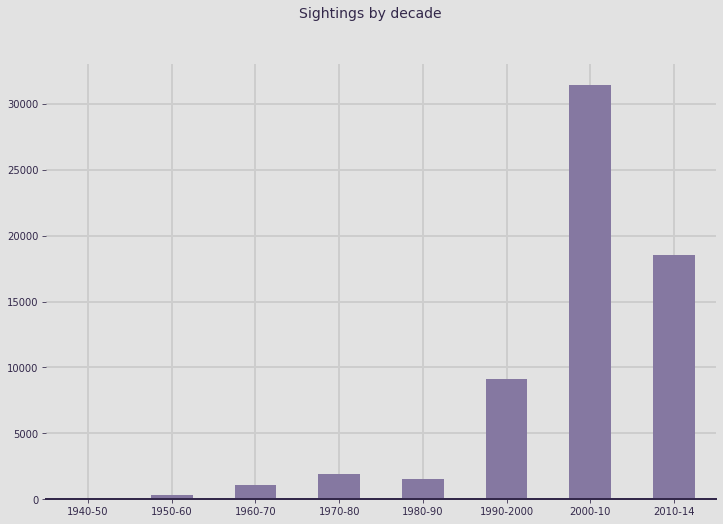

In [23]:
import matplotlib as mpl

# function to plot various categories so to maintain consistency
def plotinfo(column, title, custom=None, labels_horiz=True, df=ufo1_df, kind='bar'):
  dimensions = (12,8)
  
  fig, ax = plt.subplots(figsize=dimensions)
  fig.patch.set(facecolor='#E2E2E2')
  mpl.rcParams['savefig.facecolor'] = '#E2E2E2'

  if custom:
    ax = df[column].value_counts().sort_index().loc[custom].plot(kind=kind, 
                  color='#8578a1', zorder=2)
  else:
    ax = df[column].value_counts().sort_index().plot(kind=kind, 
                  color='#8578a1', zorder=2)
                  
  ax.set(facecolor='#E2E2E2')
  for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
  ax.spines['bottom'].set_linewidth(2)
  ax.spines['bottom'].set_color('#33284a')
  ax.tick_params(axis='both', which ='both', colors='#33284a', size=4, length=0)
  if labels_horiz:
    ax.tick_params(axis='x', rotation='auto')
  ax.grid(color='#CDCDCD', linewidth=2, zorder=0)
  fig.suptitle('Sightings by ' + title, color='#33284a', fontsize=14, horizontalalignment='center')
  fig.savefig(title)

plotinfo('decade', 'decade')


First zoom into the period from 1940 - 1970. One can see a peak at 1947 (the year of Arnold's famous 'flying saucer' sighting). Then in 1948 it drops back to 1946 levels, but form then starts to increase, with a peak of 175 settings in the end of this period.

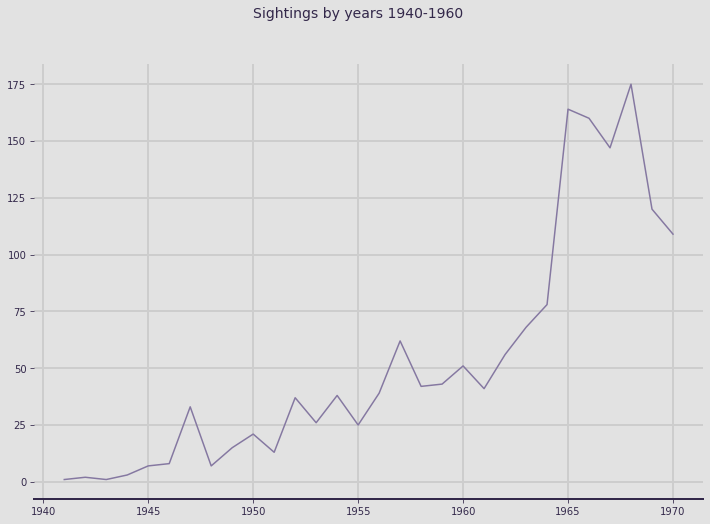

In [9]:
# From 1940-1970, year by year
plotinfo('year', 'years 1940-1960', df=ufo1_df[ufo1_df['year'] < 1971], kind='line')

The first wave of ufo sightings, centered around 1947. Incidents include Arnold's sighting (June) and the Roswell incident (July).

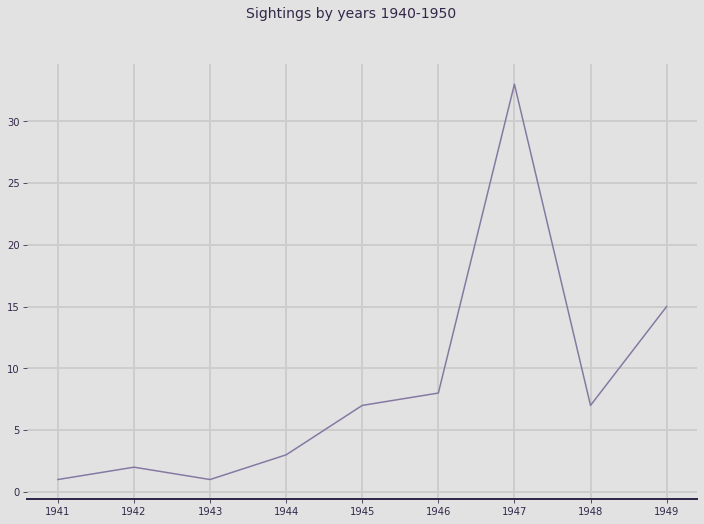

In [10]:
plotinfo('year', 'years 1940-1950', df=ufo1_df[ufo1_df['year'] < 1950], kind='line')

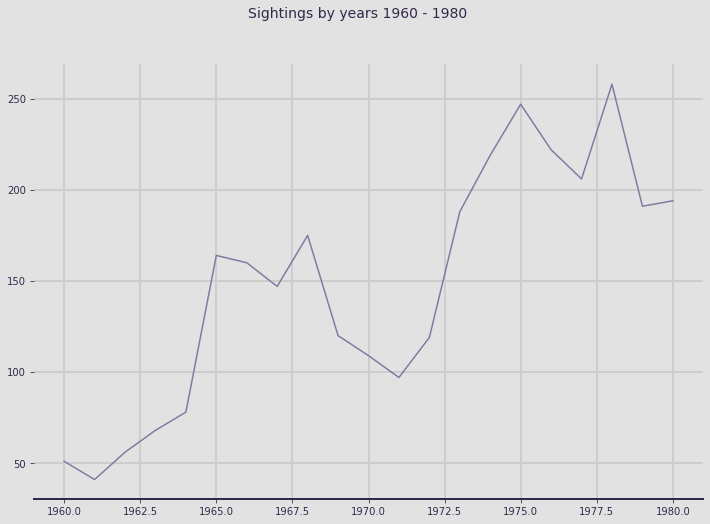

In [11]:
cond = (ufo1_df['year'] > 1959) & (ufo1_df['year'] < 1981)
plotinfo('year', 'years 1960 - 1980', df=ufo1_df[cond], kind='line')


And now zooming in  up to and into the new century, into 2013. What can be interesting is the great increase of sightings correlative with the interests in and concerns such as Y2K, the millenium, and the widespread belief that something dramatic would occur with 2012.

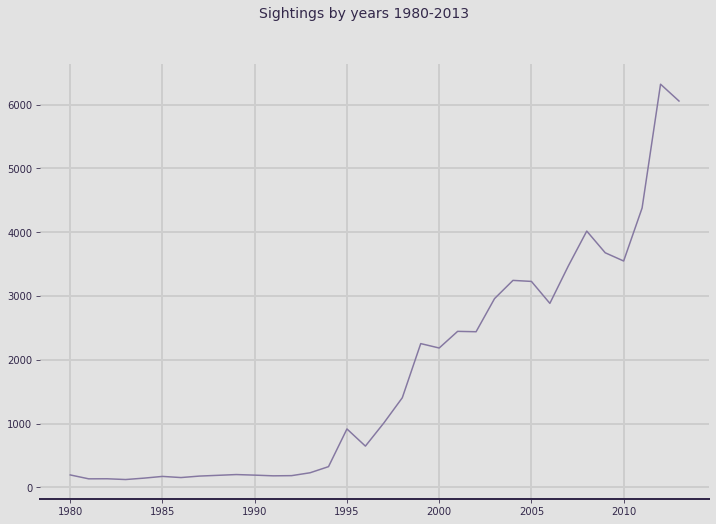

In [12]:
# From 1995 to 2013, year by year
plotinfo('year', 'years 1980-2013', df=ufo1_df[(ufo1_df['year'] > 1979) & (ufo1_df['year'] < 2014)], kind='line')

##Other Time Spans

By seasons, days of the week, and times of day. 

It seems the most sightings occur in Summer time, following Fall. Saturday is the most popular day for sightings, and the largest time of day is evening and night, between 4pm and midnight. In fact, that is the highest number of sightings is 8pm - midnight, in summertime. I thought there'd be more after midnight, but I guess fewer people are out at those times?

In [13]:
seasons = {12: 'winter', 1: 'winter', 2: 'winter',
           3: 'spring', 4: 'spring', 5: 'spring',
           6: 'summer', 7: 'summer', 8: 'summer',
           9: 'fall', 10: 'fall', 11: 'fall'}
ufo1_df['season'] = ufo1_df['datetime'].dt.month.apply(lambda x: seasons[x])
ufo1_df[['datetime', 'season']].sample(5)

,datetime,season
29903,2005-02-08 18:15:00,winter
79015,2011-09-03 23:00:00,fall
72956,2011-09-10 00:00:00,fall
45142,2013-05-30 21:55:00,spring
70366,1999-08-29 20:35:00,summer


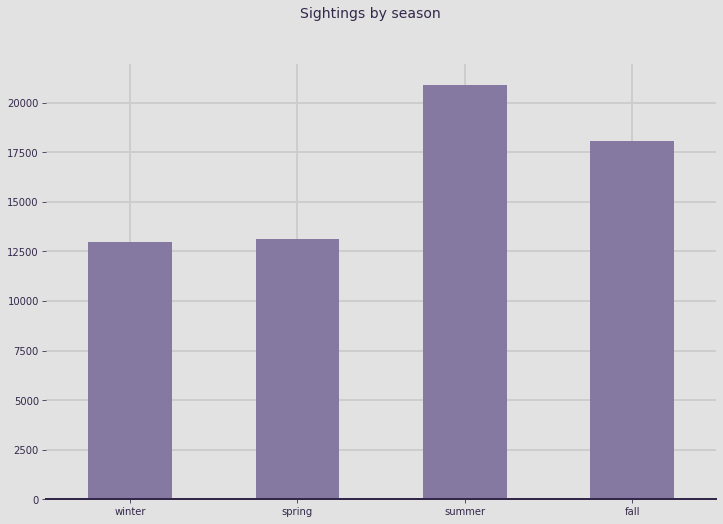

In [14]:
seasonlist = ['winter', 'spring', 'summer', 'fall']
plotinfo('season', 'season', custom=seasonlist)


In [15]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ufo1_df['weekday'] = ufo1_df['datetime'].apply(lambda x: days_of_week[x.weekday()])
ufo1_df[['datetime', 'weekday']].sample(5)

,datetime,weekday
54730,2004-07-10 23:00:00,Saturday
27963,2014-02-02 05:00:00,Sunday
21182,2006-12-29 20:00:00,Friday
72123,2008-08-07 15:00:00,Thursday
36940,2001-04-15 22:25:00,Sunday


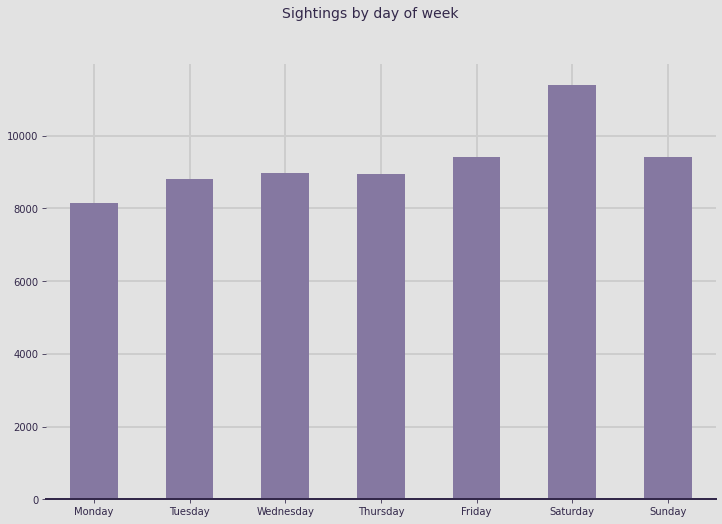

In [16]:
plotinfo('weekday', 'day of week', custom=days_of_week)

In [17]:
timeofday_bins = [0, 4, 8, 12, 16, 20, 24]
timeofday_labels = ['Midnight - 4AM', '4AM - 8AM', '8AM - Noon', 'Noon - 4PM', '4PM - 8PM', '8PM - Midnight']
ufo1_df['timeofday'] = pd.cut(ufo1_df['datetime'].dt.hour, bins=timeofday_bins, labels=timeofday_labels)
ufo1_df[['datetime', 'timeofday']].head()

,datetime,timeofday
0,1949-10-10 20:30:00,4PM - 8PM
3,1956-10-10 21:00:00,8PM - Midnight
4,1960-10-10 20:00:00,4PM - 8PM
5,1961-10-10 19:00:00,4PM - 8PM
7,1965-10-10 23:45:00,8PM - Midnight


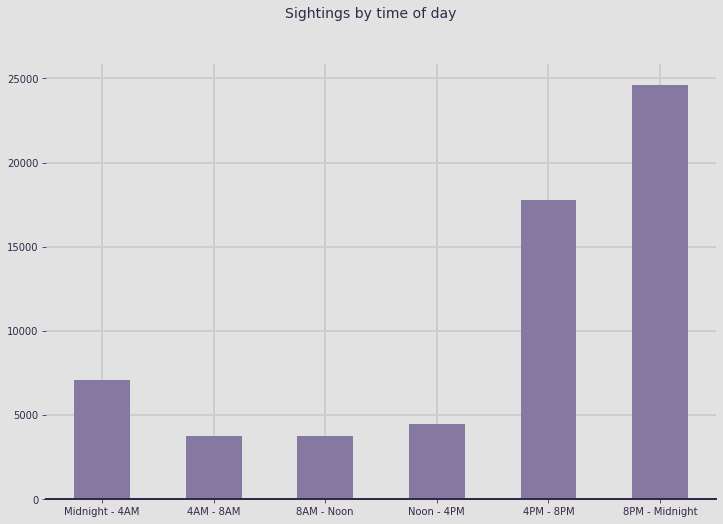

In [18]:
plotinfo('timeofday', 'time of day')

In [19]:
tod_season = pd.crosstab(ufo1_df['timeofday'], ufo1_df['season'])
tod_season

season,fall,spring,summer,winter
timeofday,,,,
Midnight - 4AM,1833,1426,2607,1241
4AM - 8AM,1304,645,687,1102
8AM - Noon,917,856,1308,668
Noon - 4PM,1152,1014,1453,864
4PM - 8PM,6490,3080,3255,4955
8PM - Midnight,5615,5371,10231,3383


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


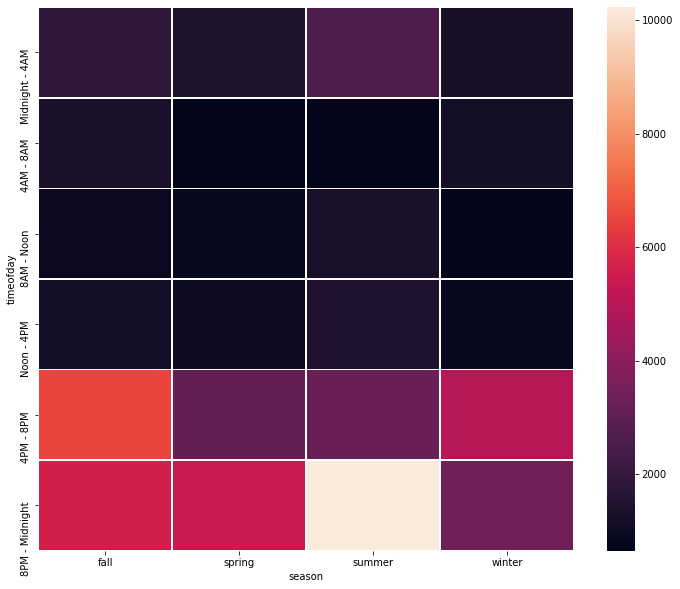

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(tod_season, linewidths=.5, ax=ax);

##Durations of Sightings

Durations included some sightings of 0 seconds, and there were outliers on the higher end of the distribution to even the equivalent of 609 days! I dropped rows in which the Duration was less than one second, and were greater than two hours in length.

Even then the wide range of durations (1 - 7200 seconds), with a very positively skewed distribution and a mean well beyond even the third quartile of the data, plotting it was not useful. So the next step was to divide it into categories (under 1 minute, 1-15 minutes, and so forth) and plot them in that manner. The majority of sightings by far turn out to be of a duration from 1 to 15 minutes. After 15 minutes they drop drastically.

In [20]:
cond = (ufo1_df['duration'] >= 1) & (ufo1_df['duration'] <= 7200)
ufo1_df = ufo1_df[cond]
ufo1_df['duration'].describe()

count    64070.000000
mean       518.391619
std       1053.707493
min          1.000000
25%         60.000000
50%        180.000000
75%        420.000000
max       7200.000000
Name: duration, dtype: float64

In [21]:
duration_bins = [0, 60, 900, 1800, 3600, 7200]
duration_labels = ['under minute', '1 - 15 minutes', '15 - 30 minutes', '30 - 60 minutes', '1 - 2 hours']
ufo1_df['length'] = pd.cut(ufo1_df['duration'], bins=duration_bins, labels=duration_labels)
ufo1_df[['duration', 'length']].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,duration,length
0,2700.0,30 - 60 minutes
3,20.0,under minute
4,900.0,1 - 15 minutes
5,300.0,1 - 15 minutes
7,1200.0,15 - 30 minutes


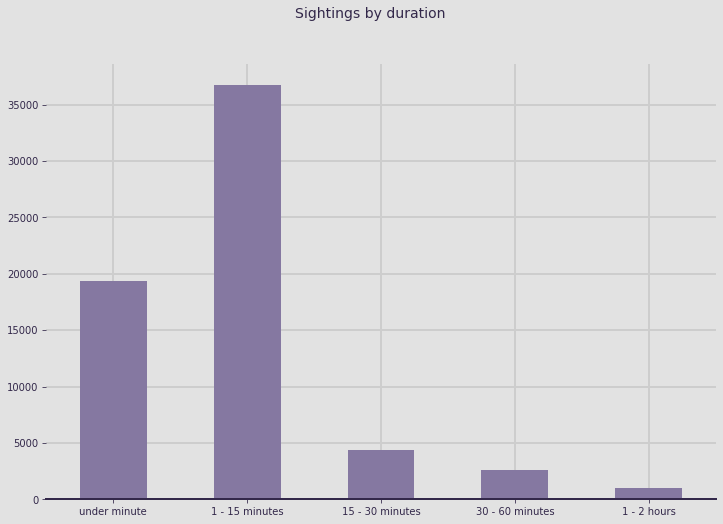

In [24]:
plotinfo('length', 'duration')

## Shapes of Objects

Which are more often lights, or circular, triangle, and other objects? By far the greatest number (twice other category) are lights in the sky. After that, circular, triangle, spehrical, and disk like objects are often seen. Fireballs are often seen. Lights and fireballs sightings may of course be misperceived astronomical phenomena (planets, meteroites, etc) or satellites. Distinctly shaped objects may be of another matter: being either (perhaps experimental) terrestrial aircraft, for example. Or...who knows what else?

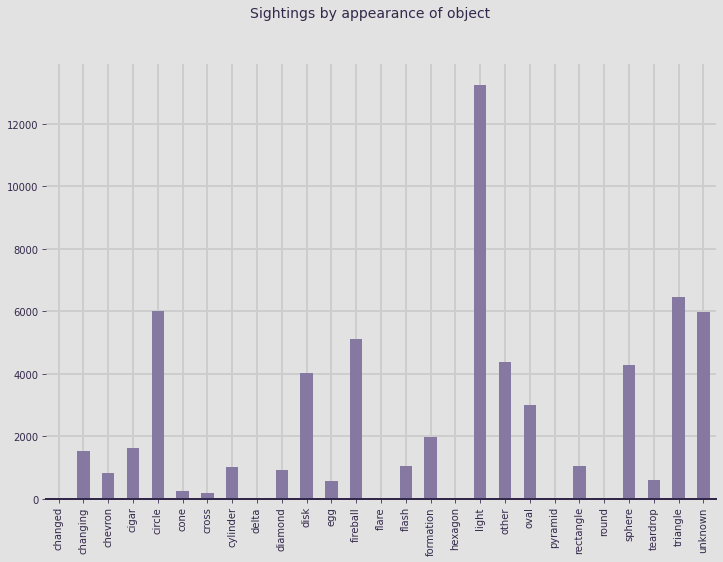

In [0]:
plotinfo('shape', 'appearance of object', labels_horiz=False)

Are there correlations of different shapes at different times? From reading on UFO phenomena, for example, I had recalled that cigar shapes seemed of an earlier period, and triangles more recent. But this does not seen to have held in this dataset. Lights seem most common though in the 2000-2010 period.

In [0]:
shape_decade = pd.crosstab(ufo1_df['shape'], ufo1_df['decade'])
shape_decade

decade,1940-50,1950-60,1960-70,1970-80,1980-90,1990-2000,2000-10,2010-14
shape,,,,,,,,
changed,0,0,0,0,0,1,0,0
changing,0,0,11,23,33,180,893,385
chevron,1,2,8,26,30,142,437,165
cigar,6,32,70,107,55,231,836,287
circle,7,39,101,174,116,619,2740,2218
cone,0,1,1,5,3,35,128,68
cross,0,0,2,4,2,20,98,62
cylinder,3,8,20,30,29,142,513,271
delta,0,0,0,1,0,4,0,0


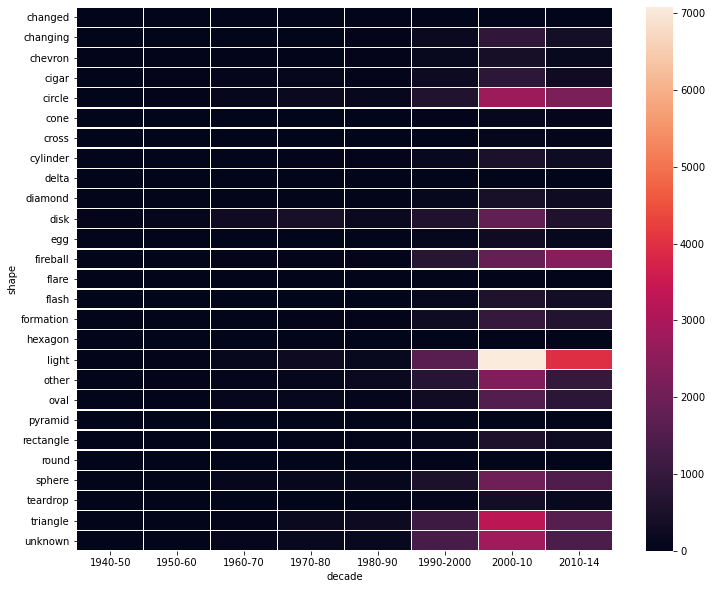

In [0]:

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(shape_decade, linewidths=.5, ax=ax);

##Sightings by State

California has the most sightings in the period, with Washington (where the popular interest began with Kenneth Arnold's sighting of a series of 'flying disks' near Mt. Ranier) ranking next at about half the level. DC seems to have none, interestingly enough (though there have been accounts of sightings, but apparently not recorded by NUFORC).

I then plot the sightings by state on choropleth of the US map.

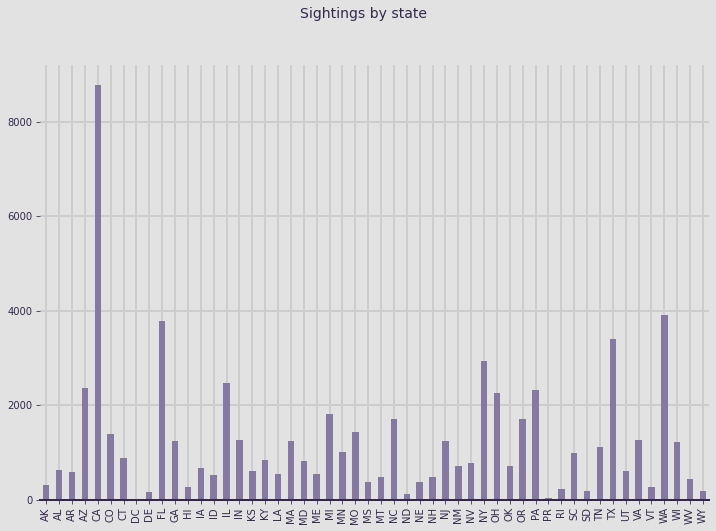

In [134]:
plotinfo('state', 'state', labels_horiz=False)

In [135]:
cases_bystate = pd.DataFrame(ufo1_df.groupby(by='state')['datetime'].count())
cases_bystate.rename(columns={'datetime': 'count'}, inplace=True)
cases_bystate.reset_index(inplace=True)
cases_bystate.head(3)

,state,count
0,AK,310
1,AL,633
2,AR,576


Using plotly choropleth map

In [137]:
fig = go.Figure( data = go.Choropleth(
    locations = cases_bystate['state'],
    z = cases_bystate['count'],
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = 'Sightings'
))

fig.update_layout(
    title_text = 'Sightings by state',
    geo_scope = 'usa',
    paper_bgcolor = '#E2E2E2',
    width = 800,
    height = 550,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=40
    )
)

fig.show()

In [93]:
# chart_studio does not seem to be available by default on colab. Guess
# it needs to be installed into the runtime.
!pip install chart_studio

     |████████████████████████████████| 71kB 1.3MB/s 


In [138]:
# Upload the result to plotly

import chart_studio
username = 'karencfisher' # your username
api_key = '9eRYhQmHRZHjt2JKbBCz' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

import chart_studio.plotly as py
py.plot(fig, filename = 'sightings_by_state', auto_open=True)

'https://plotly.com/~karencfisher/1/'

In [0]:
import chart_studio.tools as tls
tls.get_embed('https://plot.ly/~karencfisher/1/',) #change to your url

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~karencfisher/1.embed" height="525" width="100%"></iframe>'

In [139]:

state_decade = pd.crosstab(ufo1_df['state'], ufo1_df['decade'])
state_decade

decade,1940-50,1950-60,1960-70,1970-80,1980-90,1990-2000,2000-10,2010-14
state,,,,,,,,
AK,2,2,8,7,16,49,102,124
AL,2,3,17,36,10,86,285,194
AR,0,4,13,13,24,92,286,144
AZ,1,3,13,28,34,480,1204,597
CA,13,54,126,236,199,1341,4758,2042
CO,1,7,13,31,24,200,748,364
CT,0,6,26,42,28,81,361,335
DC,0,0,0,0,0,0,1,6
DE,0,1,4,4,8,17,75,55


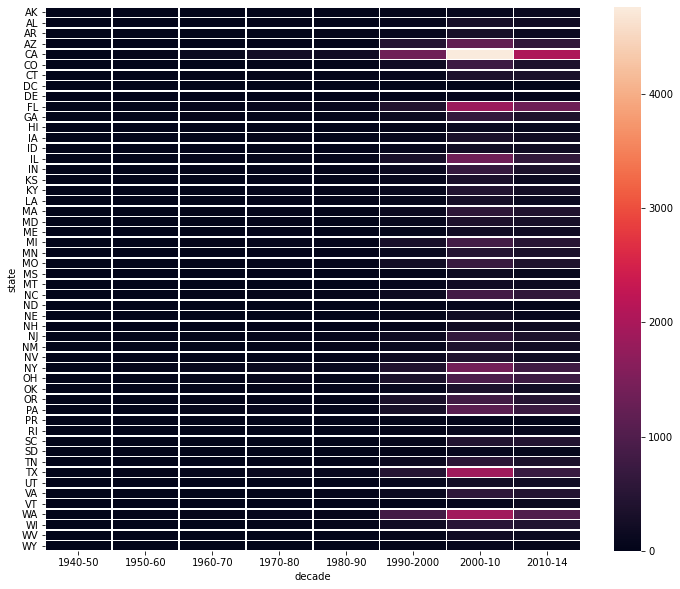

In [140]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(state_decade, linewidths=.5, ax=ax);

In [0]:
fig.savefig('state_decade.png')

##Other Correlations

Popular views suggest that there are clusters of UFO sightings of both military installations (especially airforce) and nuclear weapon sites. So perhaps the grand finale of this exploration is to see if that correlation is apparent. The dataset of military installations, with GPS coordinates, was easy to find, via https://public.opendatasoft.com/explore/dataset/military-bases/table/. For nuclear sites I had to compile by hand from https://blog.batchgeo.com/nuclear-locations-worldwide/ and Wikipedia.

In the final map, air force bases are markers, nuclear weapon sites (including Alamos National Laboratory and the major weapons Pantex plant in Texas) as red circles, and UFO sightings are purple dots. Sites are labelled as popups, the UFO sightings being by date, time, and shape of the object seen.

Alas, I cannot say those correlations hold up, at least not in this dataset. There is of course a correlation of both military installations and UFO sightings with major metropolitan areas.

One may also wonder about the veracity of the geolocation data of the sightings, and/or how they were derived. Now days of course people reporting sightings can, with the popularity of cell phones and vehicles with GPS displays, readily include such information. But other redactions of similar datasets from NUFORC's sighting reports do not inlcude coordinates. 

Load the military base dataset

In [97]:
# Get the military installation data, filter for just U.S., and drop most except what we need
bases_url = 'https://raw.githubusercontent.com/karencfisher/ufosightings/master/military-bases.csv'

bases_df = pd.read_csv(bases_url, sep=';')
bases_df = bases_df[bases_df['COUNTRY']=='United States']
bases_df = bases_df[['Geo Point', 'COMPONENT', 'Site Name', 'State Terr']]

# there were some with geolocation data missing, so drop those rows
bases_df.dropna(axis=0, inplace=True)

# translate Geo Points to latitude and longitude, replacing the Geo Points column
def fix_coords(gp, index):
  coords = gp.split(',')
  return float(coords[index])

bases_df['latitude'] = bases_df['Geo Point'].apply(fix_coords, args=(0,))
bases_df['longitude'] = bases_df['Geo Point'].apply(fix_coords, args=(1,))
bases_df.drop('Geo Point', axis=1, inplace=True)

# and just standardize column headings
bases_df.rename(columns={'COMPONENT': 'component', 'Site Name': 'site', 'State Terr': 'state'}, inplace=True)

# Filter further to just air force facilties
cond = (bases_df['component'].str.contains('AF'))
bases_df = bases_df[cond]

bases_df.head()

,component,site,state,latitude,longitude
1,Navy Active,Fort Sheridan,Illinois,42.209614,-87.806118
3,AF Active,Altus AFB,Oklahoma,34.668786,-99.270898
4,Army Active,Fort Myer,Virginia,38.878617,-77.075713
5,Army Guard,NG Rosemount Armory,Minnesota,44.747748,-93.127605
6,AF Guard,Jacksonville IAP,Florida,30.486392,-81.705440


Load the dataset of nuclear weapon sites

In [0]:
nuke_url = 'https://raw.githubusercontent.com/karencfisher/ufosightings/master/nuke_sites.csv'
nuke_sites = pd.read_csv(nuke_url)

In [143]:
nuke_sites

,name,state,latitude,longitude
0,Malstrom AFB,MT,47.504300,-111.179100
1,Nellis AFB,NV,36.241416,-115.050807
2,Warren AFB,WY,41.144685,-104.862975
3,Minot AFB,ND,48.415800,-101.338700
4,Pantex Plant,TX,35.311568,-101.559725
5,Naval Base Kitsap,WA,47.554703,-122.654629
6,Los Alamos Lab,NM,35.875663,-106.292332
7,White Sands,NM,33.677170,-106.475690
8,NV National Security Site,NV,37.023370,-116.181810
9,Tonopah Test Range,NV,37.708530,-116.657860


And put them together with sightings in an interactive map to show (or not) correlations among them.

In [144]:
# Create plotly map of US with air force bases, nuclear facilities, and sightings
# by decade.

fig = go.Figure()

# air force bases
fig.add_trace(go.Scattermapbox(
    lat=bases_df.latitude,
    lon=bases_df.longitude,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=20,
        color='blue',
        opacity=0.8
    ),
    text=bases_df.site,
    hoverinfo='text',
    name='AF Bases'
))

# nuclear sites
fig.add_trace(go.Scattermapbox(
    lat=nuke_sites.latitude,
    lon=nuke_sites.longitude,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=20,
        color='red',
        opacity=0.8
    ),
    text=nuke_sites.name,
    hoverinfo='text',
    name='Nuclear Sites'
))

# add a layer for each decade of sightings
for  dec in decade_labels[::-1]:
  viz = dec == '2010-14'
  temp = ufo1_df[ufo1_df['decade'] == dec]
  fig.add_trace(go.Scattermapbox(
    lat=temp.latitude,
    lon=temp.longitude,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=8,
        color='purple',
        opacity=0.3
    ),
    text=bases_df.site,
    hoverinfo='text',
    name='UFO Sightings',
    visible=viz
  ))

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(mapbox=dict(center=dict(lat=40, lon= -95),
                              zoom=3.7))
fig.update_layout(margin={'r': 0, 't': 0, 'l':0, 'b':0})

# Implement the drop down list to turn layers on and off to update display
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                  dict(label='2010-14',
                       method='update',
                       args=[{"visible": [True, True, True, False, False, False,
                                          False, False, False, False]}]),
                  dict(label='2000-10',
                        method='update',
                        args=[{"visible": [True, True, False, True, False, False,
                                          False, False, False, False]}]),
                  dict(label='1990-00',
                        method='update',
                        args=[{"visible": [True, True, False, False, True, False,
                                          False, False, False, False]}]),
                  dict(label='1980-90',
                        method='update',
                        args=[{"visible": [True, True, False, False, False, True,
                                          False, False, False, False]}]),
                  dict(label='1970-80',
                        method='update',
                        args=[{"visible": [True, True, False, False, False, False,
                                          True, False, False, False]}]),
                  dict(label='1960-70',
                        method='update',
                        args=[{"visible": [True, True, False, False, False, False,
                                          False, True, False, False]}]),
                  dict(label='1950-60',
                        method='update',
                        args=[{"visible": [True, True, False, False, False, False,
                                          False, False, True, False]}]),
                  dict(label='1940-50',
                        method='update',
                        args=[{"visible": [True, True, False, False, False, False,
                                          False, False, False, True]}]),
            ])
        )
    ]
)
fig.show()

In [0]:
# Chart is too large to upload to plotly withou a paid account.
# Convert the result to HTML, which can then be downloaded or otherwise used.
import plotly.io as pio
pio.write_html(fig, file='sightings.html', auto_open=True)